# Сентимент анализ сообщений Twitter

In [1]:
import pandas as pd
import numpy as np
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk import FreqDist, classify, NaiveBayesClassifier
from sklearn.feature_extraction.text import CountVectorizer
import re, string, random

In [2]:
file = 'eng_data.xlsx'
data = pd.ExcelFile(file).parse()

In [3]:
data.head()

,tweet,sentiment
0,#stl we war ready #ripmikebrown #ferguson http...,2
1,one of the best moments from ystrdy was when a...,2
2,public art. canfield. photo. #ferguson http://...,3
3,canfield. public art cont. #ferguson http://if...,3
4,public art exhibit. canfield. #ferguson http:/...,3


In [4]:
data.shape

(1205, 2)

In [5]:
data.describe()

,sentiment
count,1205.000000
mean,2.378423
std,0.742313
min,1.000000
25%,2.000000
50%,3.000000
75%,3.000000
max,3.000000


In [6]:
tweets = list(data['tweet'])

In [7]:
y = list(data['sentiment'])

In [8]:
def remove_noise(tweet_tokens, stop_words = ()):
    cleaned_tokens = []
    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)

        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)
        if token != '':
            if token[0] == '#':
                token = token[1:]
        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words\
                                                                and token.count('pic.twitter') == 0:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

def clean_review(review):
    
    review = re.sub("[^A-Za-z]", " ", review)
    review = review.lower()
    review = word_tokenize(review)
    stemmer = PorterStemmer()
    review = [stemmer.stem(word) for word in review if word not in set(stopwords.words("english"))]
    review = " ".join(review)
    return review

In [9]:
stop_words = stopwords.words('english')

In [10]:
from nltk.tokenize import casual_tokenize
tokens_tweets = []
for tweet in tweets:
        tokens_tweets.append(casual_tokenize(tweet))

In [11]:
clean_token_tweets = []
for token in tokens_tweets:
        clean_token_tweets.append(remove_noise(token, stop_words))

In [12]:
clean_token_tweets[0]

['stl', 'war', 'ready', 'ripmikebrown', 'ferguson']

In [13]:
def joinmy(review):
    review = " ".join(review)
    return review
clean_token_tweets_predl = [joinmy(i) for i in clean_token_tweets ]

In [416]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
values = tfidf_vectorizer.fit_transform(clean_token_tweets_predl)

In [417]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(values, y, test_size = 0.3, random_state = 11)

In [418]:
X_test.shape

(362, 2933)

In [419]:
X_train.shape

(843, 2933)

## Обучение классическими метоами

In [420]:
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

In [421]:
rfc = ensemble.RandomForestClassifier(n_jobs=-1)
param_grid = {
    'n_estimators': [100,200,300],
    'max_features': ['auto', 'sqrt', 'log2']
}
CV_rfc = GridSearchCV(rfc, param_grid=param_grid, cv= 3)
CV_rfc.fit(X_train, y_train)

print (CV_rfc.best_params_)

{'max_features': 'auto', 'n_estimators': 300}


In [422]:
rf = ensemble.RandomForestClassifier(n_jobs=-1,max_features='log2',n_estimators=200)
rf.fit(X_train, y_train)
err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))
print (err_train, err_test)

0.0035587188612099642 0.35082872928176795


## Тест модуль

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix as conf_matr
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

def score_test(y_true,y_pred):#на вход истинные метки и предсказанные
    
    cm = conf_matr(y_true,y_pred) #обычная
    cmn = conf_matr(y_true,y_pred,normalize ='true') #нормированная
    class_names = ['positive','negative','neutral']

    #строим графики
    for matr in [cm,cmn]:
        disp = ConfusionMatrixDisplay(confusion_matrix=matr,display_labels=class_names)
        disp = disp.plot(cmap=plt.cm.Blues)

    plt.show()
    print(cm,'\n','\n',cmn,'\n')
    accuracy = accuracy_score(y_true,y_pred)
    f1 = f1_score(y_true,y_pred,average = 'weighted')
    print(f'accuracy = {accuracy}')
    print(f'F1 score = {f1}')

In [424]:
# from test import score_test

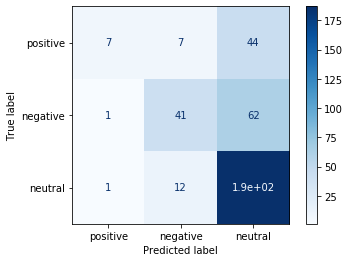

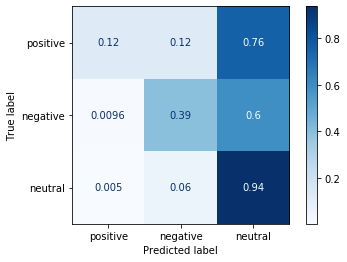

[[  7   7  44]
 [  1  41  62]
 [  1  12 187]] 
 
 [[0.12068966 0.12068966 0.75862069]
 [0.00961538 0.39423077 0.59615385]
 [0.005      0.06       0.935     ]] 

accuracy = 0.649171270718232
F1 score = 0.596252875458865


In [425]:
score_test(y_test,rf.predict(X_test))

## Обучение нейронками

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from tqdm.notebook import tqdm
from pathlib import Path
import requests
import pickle
import spacy
import os
import torchtext
from torchtext import vocab

### CNN

In [325]:
set_of_word = set()
for sentence in clean_token_tweets:
    for word in sentence:
        set_of_word.add(word)
dict_of_word_3030 = {}
j = 1
for word in set_of_word:
    dict_of_word_3030[word] = j
    j += 1
dict_of_word_3030['<pad>'] = 3031        

In [394]:
class CNN(nn.Module):

    def __init__(self, vocab_size, embedding_dim,n_filters, filter_sizes, output_dim, dropout):

        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=n_filters,
                      kernel_size=(fs, embedding_dim)) for fs in filter_sizes])

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        text = text.permute(1, 0)

        embedded = self.embedding(text)

        embedded = embedded.unsqueeze(1)

        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]

        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2)
                  for conv in conved]

        cat = self.dropout(torch.cat(pooled, dim=1))
        x = self.fc(cat)
        return x


In [397]:
def make_clean_tweet_for_nn(sentense):
    min_len = 7
    if len(sentense) < min_len:
        sentense += ['<pad>'] * (min_len - len(sentense))  
    
    indexed = np.array([dict_of_word_3030[word] for word in sentense])
    tensor = torch.LongTensor(indexed)
    tensor = tensor.unsqueeze(1)
    return tensor

In [461]:
cl_tweats_for_nn = [make_clean_tweet_for_nn(tweet) for tweet in clean_token_tweets ]
true_labels = [i-1 for i in y.copy()]
dataset =[i for i in zip(cl_tweats_for_nn,true_labels)]
validation_split = 0.3
shuffle_dataset = True

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [462]:
CNN_neur = CNN(3032, 300, 120, [3, 4, 5, 7], 3, 0.55)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 3e-4
optimizer = torch.optim.Adam(CNN_neur.parameters(), lr=learning_rate)
losses = []

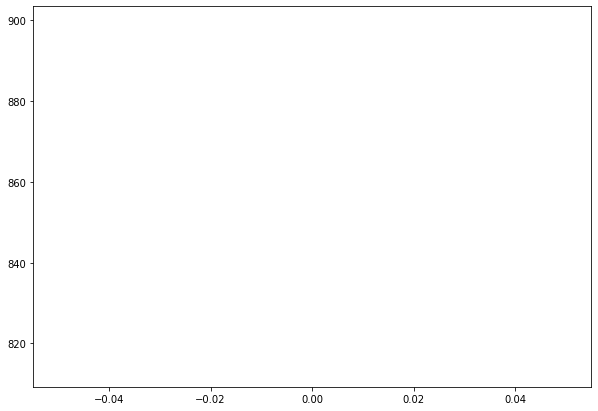

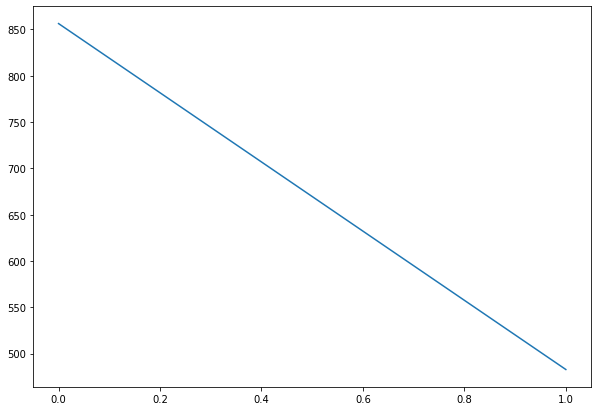

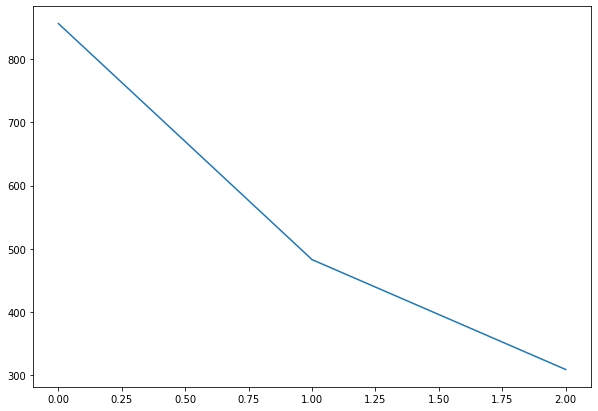

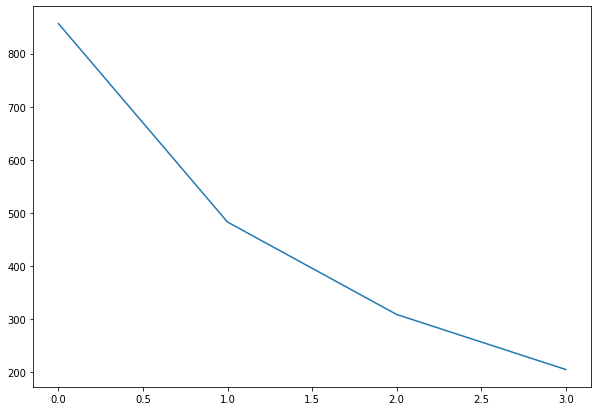

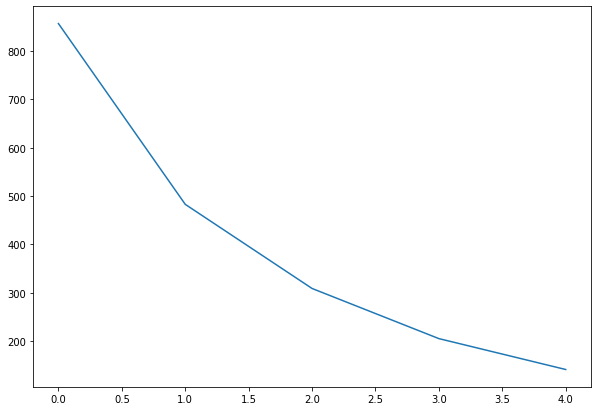


Обучение закончено


In [463]:
CNN_neur.train()
for epoch in tqdm(range(5)):
    running_loss = 0.0
    optimizer.zero_grad()
    for i, batch in enumerate(tqdm(train_indices)):
        
        X_batch, y_batch = dataset[batch]

        # forward + backward + optimize
        y_pred = CNN_neur(X_batch)
        loss = loss_fn(y_pred, torch.LongTensor([y_batch]))
        loss.backward()
        if i % 15 == 0 or i in [801,802,803,804,805]:
            optimizer.step()
            optimizer.zero_grad()       
        running_loss += loss.item()
    
    losses.append(running_loss)
    plt.figure(figsize=(10,7))
    plt.plot(np.arange(len(losses)), losses)
    plt.show()

print('Обучение закончено')

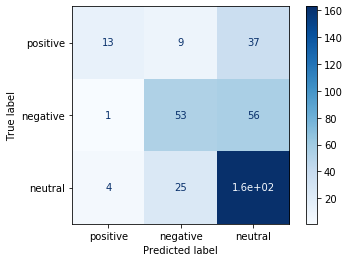

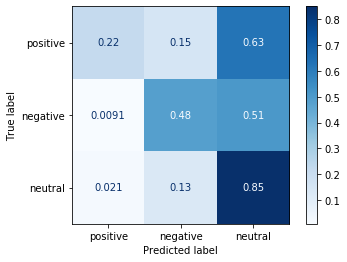

[[ 13   9  37]
 [  1  53  56]
 [  4  25 163]] 
 
 [[0.22033898 0.15254237 0.62711864]
 [0.00909091 0.48181818 0.50909091]
 [0.02083333 0.13020833 0.84895833]] 

accuracy = 0.6343490304709142
F1 score = 0.6061611659148114


In [464]:
pred_neur = []
real_labels = []
CNN_neur.eval()
with torch.no_grad():
    for i in val_indices:
        tweets, labels = dataset[i]
        y_pred = CNN_neur(tweets)
        predsk = int(torch.argmax(F.softmax(y_pred,dim=1)))
        pred_neur.append(predsk)
        real_labels.append(labels)
pred_neur = pred_neur
real_labels = real_labels
score_test(real_labels,pred_neur)

In [472]:
# torch.save(CNN_neur.state_dict(),"C:/Users/admin_i/origin_project_py/sentiment_analysis/Relise/NN-Twitter/best_score_model.pth")

### Многослойный

In [368]:
class NN(nn.Module):

    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(100, 256)
        self.dropout1 = nn.Dropout(0.55)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 3)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [205]:
cl_tweats_for_nn = torch.FloatTensor(data_mean)
# true_labels = [i-1 for i in y] #гдето наверху
true_labels = y.copy()
for i in range(len(true_labels)):
    
    if true_labels[i]== 1:
        true_labels[i] = 2
    elif true_labels[i] == 2:
        true_labels[i] = 0
    elif true_labels[i] == 3:
        true_labels[i] = 1
    
        
dataset =[i for i in zip(cl_tweats_for_nn,true_labels)]

In [206]:
batch_size = 20
validation_split = 0.2
shuffle_dataset = True


dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]


train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


In [215]:
#выбор функицй оптимизации, модели и т.д
net = NN()
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-2
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
losses = []

In [252]:
rubanga = next(iter(train_loader))
loss_fn(net(rubanga[0][0:1]),rubanga[1][0:1])

tensor(0.6309, grad_fn=<NllLossBackward>)

In [262]:
print(rubanga[1][0:1])

tensor([1])


In [268]:
kaka = torch.Tensor([5,]).squeeze

In [269]:
type(kaka)

builtin_function_or_method

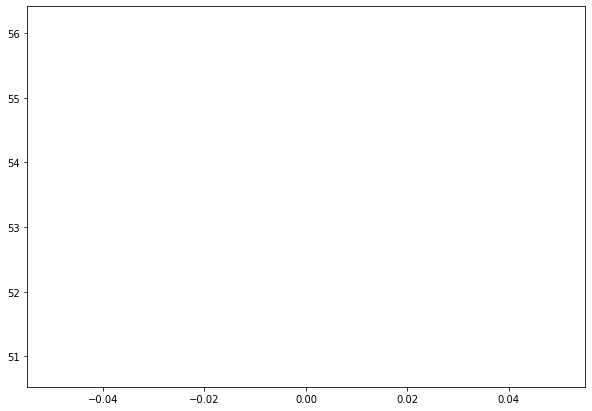

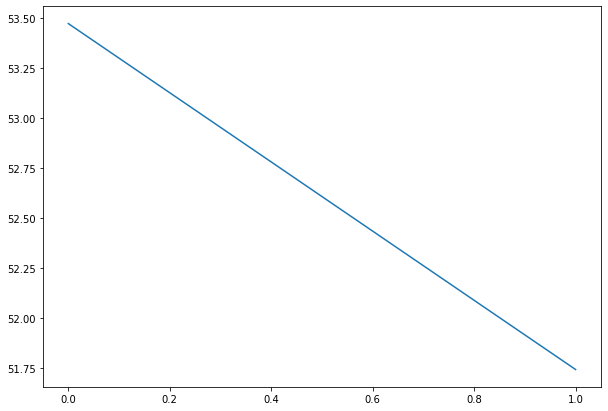

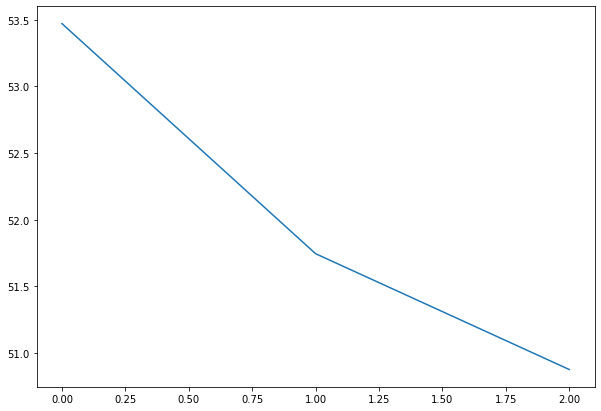

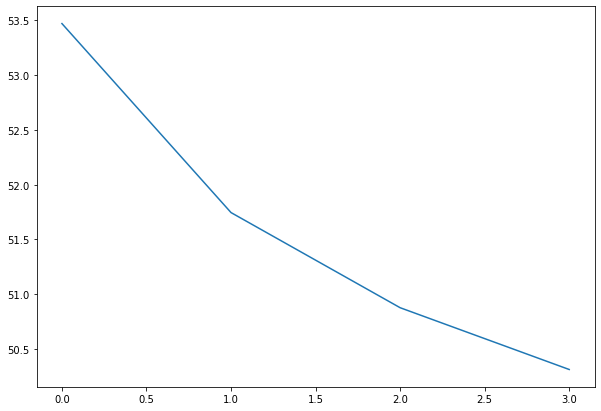

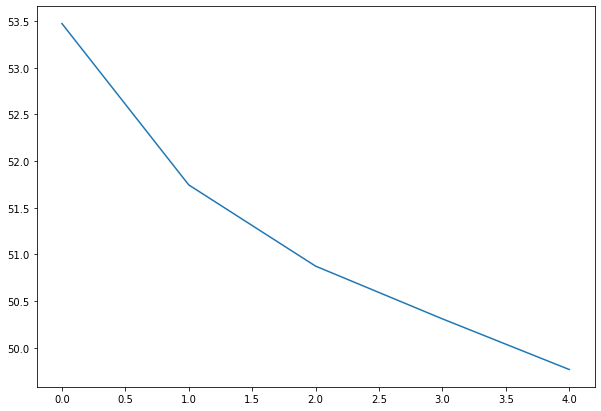

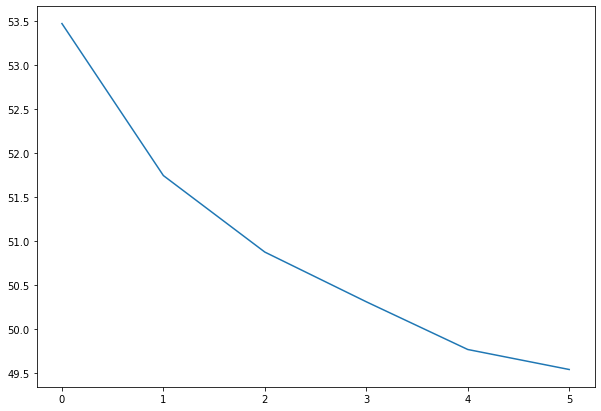

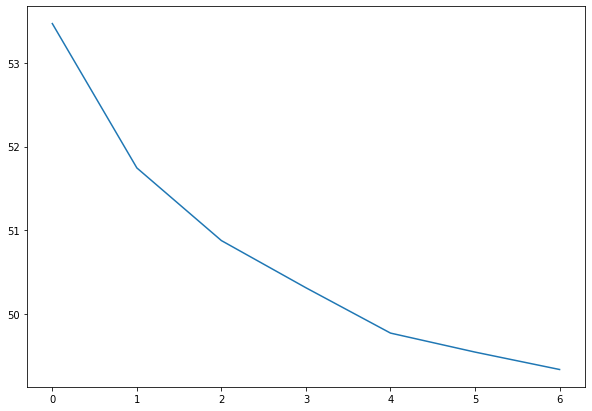

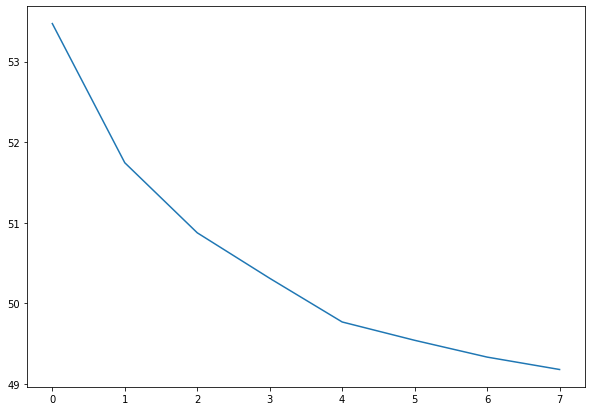

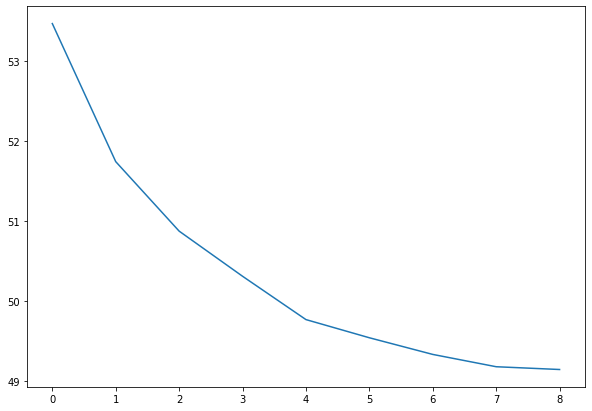

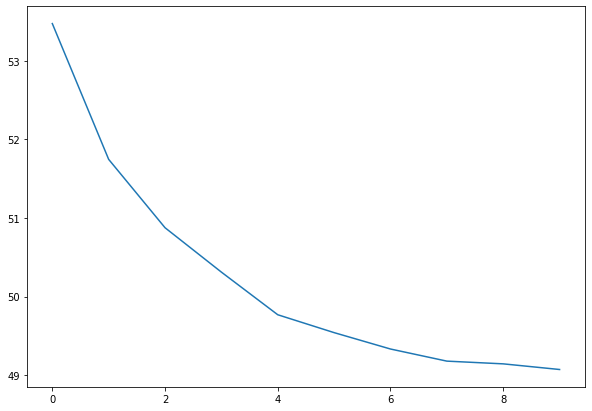

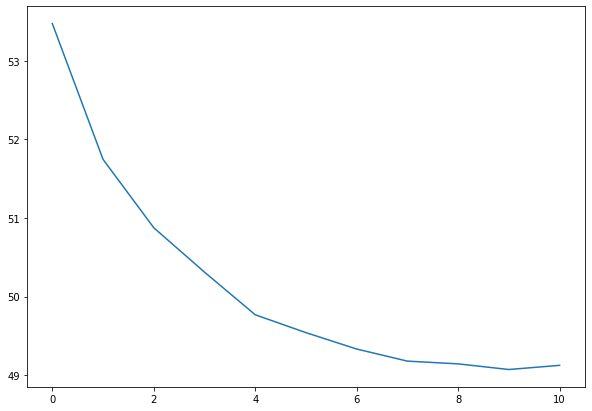

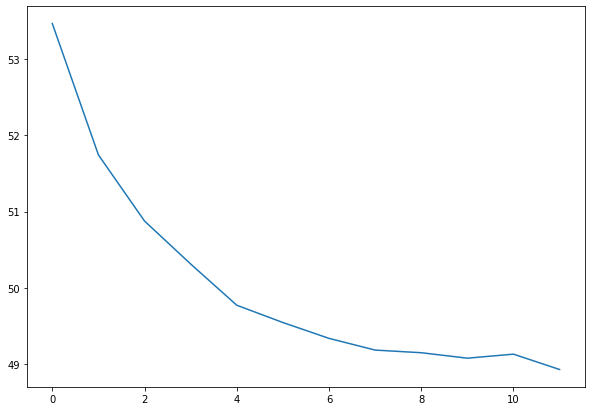

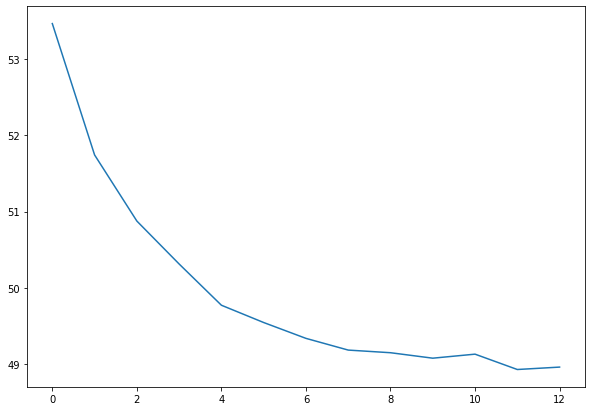

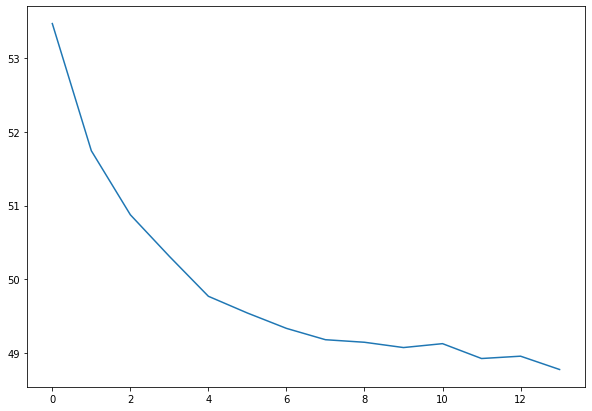

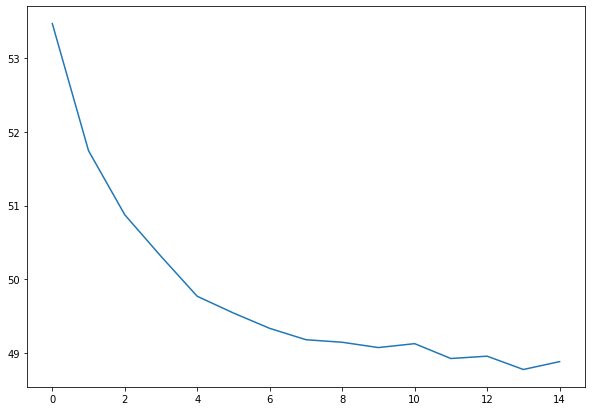

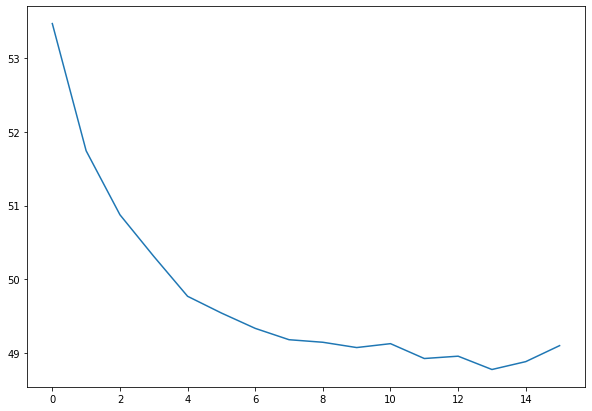

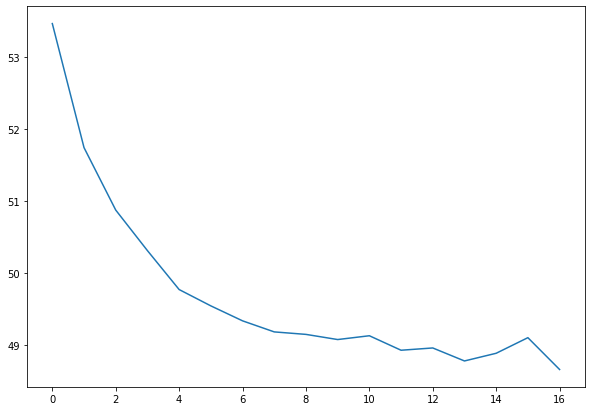

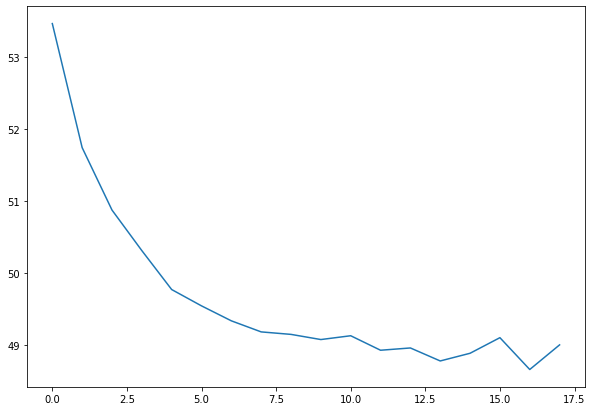

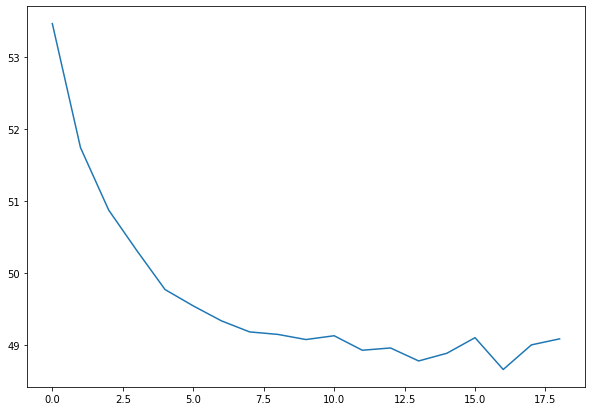

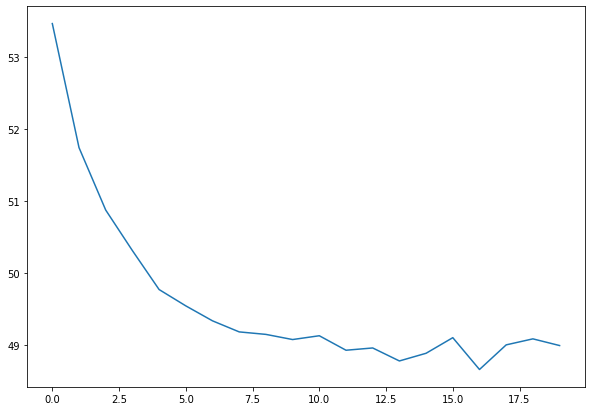


Обучение закончено


In [218]:
for epoch in tqdm(range(20)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm(train_loader)):

        X_batch, y_batch = batch
        

        optimizer.zero_grad()


        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    losses.append(running_loss)
    plt.figure(figsize=(10,7))
    plt.plot(np.arange(len(losses)), losses)
    plt.show()

print('Обучение закончено')

In [516]:
flatten = lambda l: [item for sublist in l for item in sublist]

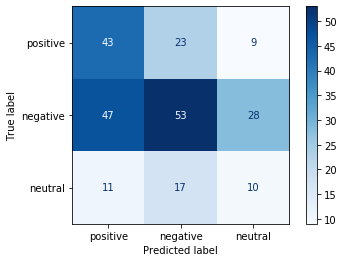

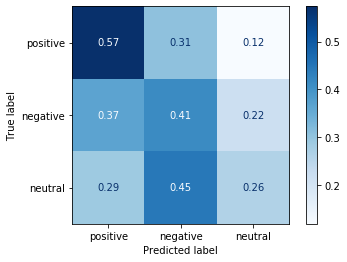

[[43 23  9]
 [47 53 28]
 [11 17 10]] 
 
 [[0.57333333 0.30666667 0.12      ]
 [0.3671875  0.4140625  0.21875   ]
 [0.28947368 0.44736842 0.26315789]] 

accuracy = 0.43983402489626555
F1 score = 0.44391107428085697


In [526]:
pred_neur = []
real_labels = []
net.eval()
with torch.no_grad():
    for datas in validation_loader:
        tweets, labels = datas
        y_pred = net(tweets)
        pred_neur.append(np.argmax(F.softmax(y_pred,dim=0).data.numpy(),axis=1))
        real_labels.append(labels)
pred_neur = flatten(pred_neur)
real_labels = flatten(real_labels)
score_test(real_labels,pred_neur)